In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [2]:
def map_technology(df):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df

## Load scenario results

In [3]:
file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

In [4]:
def get_curtailment(results_edge_flows):
    '''Get curtailment flows
    '''
    return results_edge_flows[results_edge_flows.to_id.str.contains('curtailment')].reset_index(drop=True)

def get_total_curtailment(results_edge_flows):
    '''Get total curtailment per hour per day
    '''
    curtailment = get_curtailment(results_edge_flows)
    return curtailment.groupby(by=['to_id','hour','day','month','scenario']).sum().reset_index() 

def get_generation(results_edge_flows):
    '''Get generation flows
    '''
    # drop generation
    generation = results_edge_flows[ (~results_edge_flows.from_id.str.contains('_generation'))].reset_index(drop=True)
    # drop curtailment flows
    generation = generation[ (~generation.to_id.str.contains('curtailment'))].reset_index(drop=True)
    # drop non-sources
    nodes_to_remove = ['egypt_generation',
                       'israel_battery_storage',
                       'jordan_battery_storage',
                       'west_bank_battery_storage',
                       'gaza_battery_storage',
                      ]
    # remove
    generation = generation[ (~generation.from_id.isin(nodes_to_remove))].reset_index(drop=True)
    return generation

def get_total_generation(results_edge_flows):
    '''Get total generation
    '''
    generation = get_generation(results_edge_flows)
    # rename to_id to common type
    generation['to_id'] = 'total_generation'    
    # group to daily totals
    total_generation = generation.groupby(by=['to_id','hour','day','month','scenario']).sum().reset_index()
    return total_generation

def get_res_uptake(results_edge_flows):
    '''Get curtailment and RES uptake figures
    '''
    total_curtailment = get_total_curtailment(results_edge_flows)
    total_generation = get_total_generation(results_edge_flows)
    # join dfs
    joined = total_curtailment.join(total_generation.set_index(['hour','day','month']), on=['hour','day','month'], lsuffix='_curtail', rsuffix='_generation')
    #rename
    joined['scenario'] = joined['scenario_curtail']
    #reindex
    joined = joined[['hour','day','month','scenario','value_curtail','value_generation']]
    #sum
    joined['total_supply'] = joined['value_curtail'] + joined['value_generation']
    # res_uptake
    #joined['res_uptake_%'] = joined['value_generation'] / joined['total_supply'] * 100
    return joined

def get_storage_levels(results_storages):
    '''Return daily storage levels per month
    '''
    results_storages = results_storages.groupby(by=['hour','day','month','scenario']).mean().reset_index()
    #results_storages = results_storages.groupby(by=['day','month','scenario']).mean().reset_index()
    results_storages['capacity_%'] = results_storages['value'] / results_storages['value'].max() * 100
    # remove zeros
    results_storages = results_storages[results_storages['capacity_%']>0].reset_index(drop=True)
    # add 20 to make minimum level 20% : protects battery
    results_storages.loc[results_storages['capacity_%'] < 80, 'capacity_%'] = \
            results_storages.loc[results_storages['capacity_%'] < 80, 'capacity_%'] + 20
    return results_storages

In [5]:
#--
# COO

# get edge flow results
COO = get_res_uptake(results['COO'].results_edge_flows)
# group daily
COO = COO.groupby(by=['day','month','scenario']).sum().reset_index()

# get storage results
COO_storages = get_storage_levels(results['COO'].results_storages)

#--
# NCO

NCO = get_res_uptake(results['NCO'].results_edge_flows)
# group daily
NCO = NCO.groupby(by=['day','month','scenario']).sum().reset_index()

# get storage results
NCO_storages = get_storage_levels(results['NCO'].results_storages)

#--
# Append and plot

combined = NCO.append(COO,ignore_index=True)
combined_storages = NCO_storages.append(COO_storages,ignore_index=True)

# pctg curtailment
combined['curtail_%'] = combined['value_curtail'] / combined['total_supply'] * 100
# pctg uptake
combined['res_uptake_%'] = combined['value_generation'] / combined['total_supply'] * 100

In [6]:
combined_storages

,hour,day,month,scenario,year,timestep,value,capacity_%
0,1,1,2,NCO,2030.0,745.0,87.570704,23.985015
1,1,1,3,NCO,2030.0,1417.0,484.727905,42.058151
2,1,1,4,NCO,2030.0,2161.0,611.765283,47.839146
3,1,1,5,NCO,2030.0,2881.0,632.808727,48.796754
4,1,1,6,NCO,2030.0,3625.0,386.106451,37.570258
...,...,...,...,...,...,...,...,...
12057,24,29,10,COO,2030.0,7248.0,336.860221,83.166577
12058,24,30,1,COO,2030.0,720.0,67.006961,36.543181
12059,24,30,7,COO,2030.0,5064.0,7.950000,21.962756
12060,24,30,9,COO,2030.0,6552.0,157.360633,58.850373


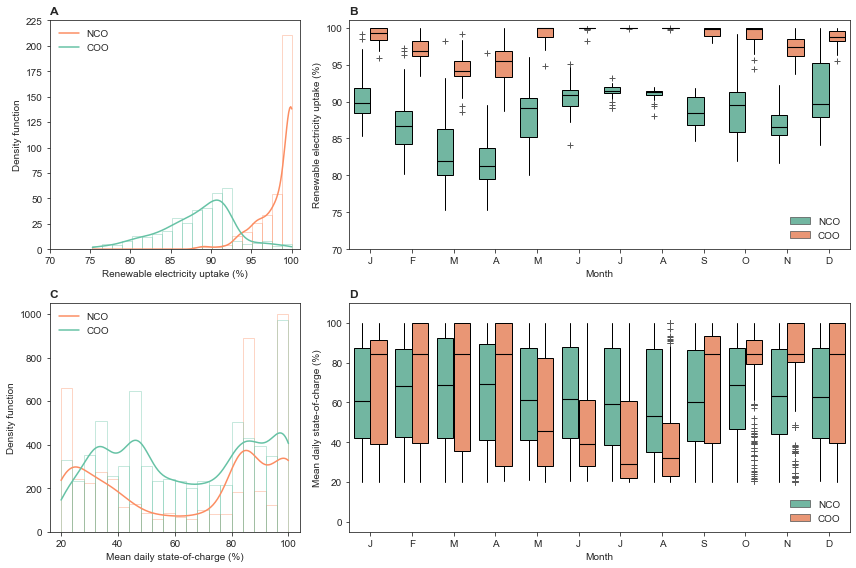

In [9]:
# plot

f,ax  = plt.subplots(nrows=2,ncols=2,figsize=(12,8), gridspec_kw={'width_ratios': [1, 2]})

sns.set_style("ticks")

#--
# HISTOGRAM: RES UPTAKE

sns.histplot(combined, 
            x="res_uptake_%", 
            hue="scenario",
            alpha=0.4, 
            fill=False,
            kde=True,
            palette='Set2',
            bins=20,
            ax=ax[0,0],
           )

ax[0,0].set_ylim([0,225])
ax[0,0].set_xlim([70,101])
ax[0,0].set_ylabel('Density function')
ax[0,0].set_xlabel('Renewable electricity uptake (%)')
ax[0,0].legend(title=None, loc='upper left', labels=['NCO', 'COO'], frameon=False)
ax[0,0].set_title('A',fontweight='bold',loc='left')

#--
# BOXPLOT: RENEWABLE UPTAKE

g = sns.boxplot(data=combined,
            x='month',
            y='res_uptake_%',
            hue='scenario',
            palette='Set2',
            showfliers=True,
            boxprops = dict(linewidth=1, edgecolor='black'),
            medianprops = dict(linestyle='-', linewidth=1.1, color='black'),
            whiskerprops = dict(linestyle='-',color='black',linewidth=1),
            capprops = dict(linestyle=''),
            flierprops = dict(marker='+', markerfacecolor='lightgray', 
                              markersize=6,linestyle='none'),
            ax=ax[0,1],
           )

#ax[1].set_xlim([-1,12])
ax[0,1].set_title('B',fontweight='bold',loc='left')
ax[0,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax[0,1].set_ylim([70,101])
ax[0,1].set_xlabel('Month')
ax[0,1].set_ylabel('Renewable electricity uptake (%)')
g.legend(frameon=False, loc='lower right')

#--
# HISTOGRAM: STORAGE VOLUMES

sns.histplot(combined_storages, 
            x="capacity_%", 
            hue="scenario",
            alpha=0.4, 
            fill=False,
            kde=True,
            palette='Set2',
            bins=20,
            ax=ax[1,0],
           )

#ax[1,0].set_ylim([0,110])
#ax[1,0].set_xlim([70,101])
ax[1,0].set_ylabel('Density function')
ax[1,0].set_xlabel('Mean daily state-of-charge (%)')
ax[1,0].legend(title=None, loc='upper left', labels=['NCO', 'COO'], frameon=False)
ax[1,0].set_title('C',fontweight='bold',loc='left')

#--
# BOXPLOT: STORAGE VOLUMES

g = sns.boxplot(data=combined_storages,
                x='month',
                y='capacity_%',
                hue='scenario',
                palette='Set2',
                showfliers=True,
                boxprops = dict(linewidth=1, edgecolor='black'),
                medianprops = dict(linestyle='-', linewidth=1.1, color='black'),
                whiskerprops = dict(linestyle='-',color='black',linewidth=1),
                capprops = dict(linestyle=''),
                flierprops = dict(marker='+', markerfacecolor='lightgray', 
                              markersize=6,linestyle='none'),
                ax=ax[1,1],
               )

ax[1,1].set_ylim([-5,110])
ax[1,1].set_title('D',fontweight='bold',loc='left')
ax[1,1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
#ax[1,1].set_ylim([70,101])
ax[1,1].set_xlabel('Month')
ax[1,1].set_ylabel('Mean daily state-of-charge (%)')
g.legend(frameon=False, loc='lower right')

f.tight_layout()

f.savefig('../outputs/figures/OMS_renewable_uptake.png',dpi=450)